In [1]:
# !pip uninstall scikit-learn -y
# !pip install scikit-learn==1.3.2
# !pip install xgboost --upgrade
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! kaggle competitions download -c playground-series-s4e12

playground-series-s4e12.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# ! mkdir RegressionWithInsurance
# ! mv playground-series-s4e12.zip RegressionWithInsurance/
# ! cd RegressionWithInsurance/
# ! unzip /content/RegressionWithInsurance/playground-series-s4e12.zip

In [7]:
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

X = train_dataset.iloc[:, :-1]
y = train_dataset.iloc[:, -1]
X.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House


In [8]:
y.head()

,Premium Amount
0,2869.0
1,1483.0
2,567.0
3,765.0
4,2022.0


In [9]:
# from sklearn.preprocessing import LabelEncoder
# df2 = df[["Gender", "Marital Status", "Occupation", "Location", "Policy Type", "Customer Feedback", "Smoking Status", "Exercise Frequency", "Property Type"]]
# df["Gender"] = LabelEncoder().fit_transform(df["Gender"])
# df["Marital Status"] = LabelEncoder().fit_transform(df["Marital Status"])
# df["Occupation"] = LabelEncoder().fit_transform(df["Occupation"])
# df["Location"] = LabelEncoder().fit_transform(df["Location"])
# df["Policy Type"] = LabelEncoder().fit_transform(df["Policy Type"])
# df["Customer Feedback"] = LabelEncoder().fit_transform(df["Customer Feedback"])
# df["Smoking Status"] = LabelEncoder().fit_transform(df["Smoking Status"])
# df["Exercise Frequency"] = LabelEncoder().fit_transform(df["Exercise Frequency"])
# df["Property Type"] = LabelEncoder().fit_transform(df["Property Type"])




numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nNumberical Columns = ")
print(numerical_columns)
print(f"\nTotal number of numerical columns : {len(numerical_columns)}")

print("\nCategorical Columns = ")
print(categorical_columns)
print(f"\nTotal number of categorical columns : {len(categorical_columns)}")


Numberical Columns = 
['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

Total number of numerical columns : 9

Categorical Columns = 
['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Total number of categorical columns : 11


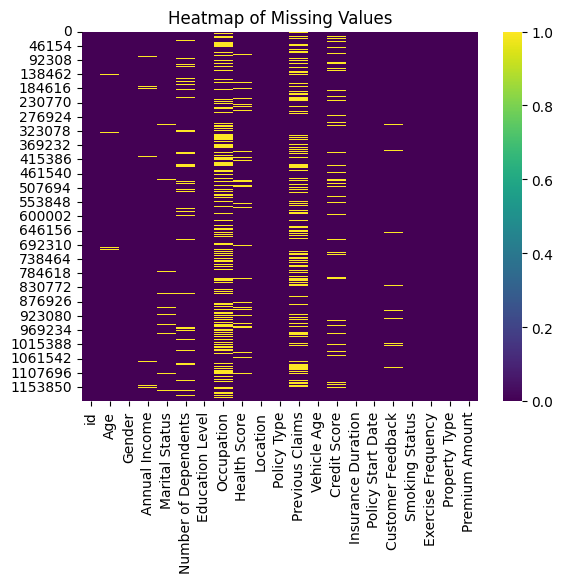

In [10]:
# Checking for Missing values
sns.heatmap(train_dataset.isnull(), cbar="False", cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.show()

In [11]:
# Counting the missing values
miss_count_train = train_dataset.isnull().sum()
miss_count_test = test_dataset.isnull().sum()

display(miss_count_train)
display(miss_count_test)

,0
id,0
Age,18705
Gender,0
Annual Income,44949
Marital Status,18529
Number of Dependents,109672
Education Level,0
Occupation,358075
Health Score,74076
Location,0


,0
id,0
Age,12489
Gender,0
Annual Income,29860
Marital Status,12336
Number of Dependents,73130
Education Level,0
Occupation,239125
Health Score,49449
Location,0


In [12]:
# Filling the missing values
train_dataset[numerical_columns] = train_dataset[numerical_columns].fillna(-1)
test_dataset[numerical_columns] = test_dataset[numerical_columns].fillna(-1)

train_dataset[categorical_columns] = train_dataset[categorical_columns].fillna("Unknown")
test_dataset[categorical_columns] = test_dataset[categorical_columns].fillna("Unknown")

print("Missing Values in the train dataset:")
print(train_dataset.isnull().sum())

Missing Values in the train dataset:
id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64


In [13]:
print("Missing Values in test dataset")
print(test_dataset.isnull().sum())

Missing Values in test dataset
id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64


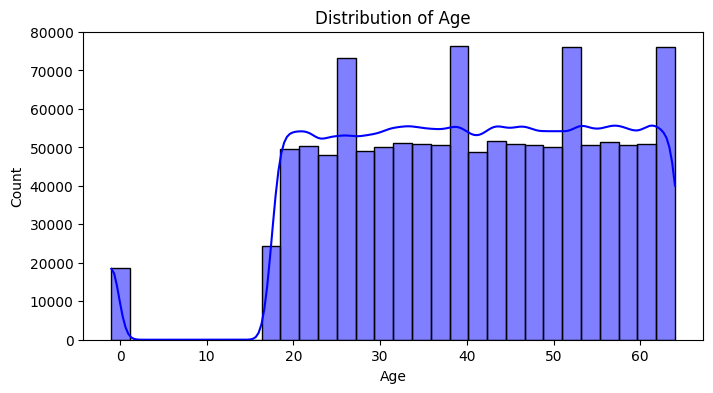

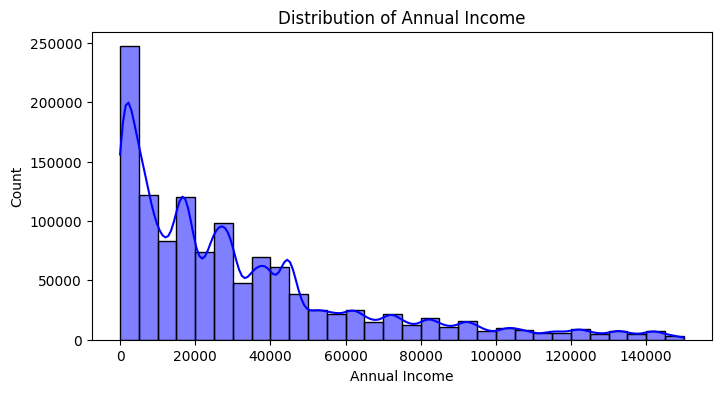

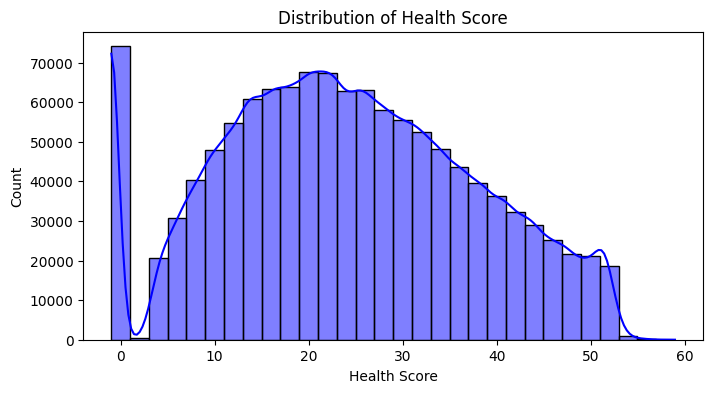

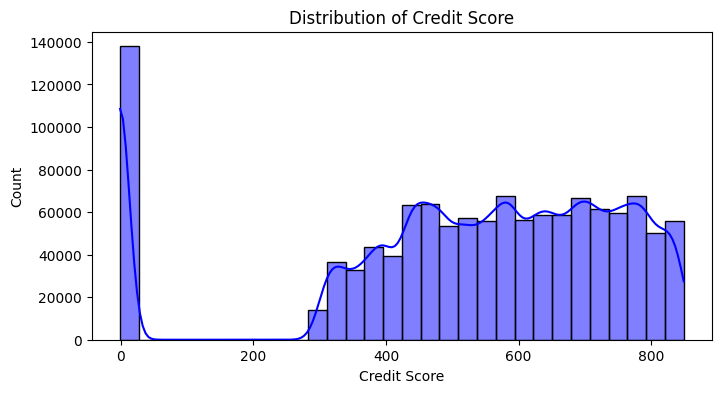

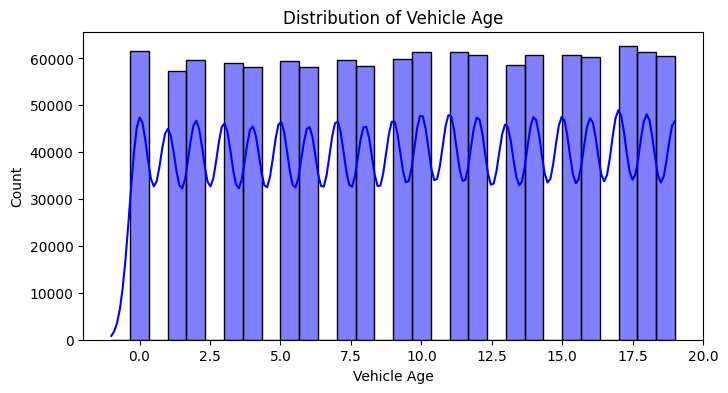

In [14]:
numerical_features = ["Age", "Annual Income", "Health Score", "Credit Score", "Vehicle Age"]

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_dataset[feature], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {feature}")
    plt.show()

In [15]:
# Training and the Teting of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
categorical_features = categorical_columns
columns_transformer = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)

    ],
    remainder="passthrough"
)

In [17]:
X_train  = columns_transformer.fit_transform(X_train)
X_test = columns_transformer.transform(X_test)

In [18]:
X_test_dataset = columns_transformer.transform(test_dataset)

In [20]:
import sklearn
sklearn.set_config(assume_finite=True)
reg = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
y_pred = reg.predict(X_test)
y_test_pred = reg.predict(X_test_dataset)

In [22]:
y_test_pred

array([1137.2184, 1118.9396, 1082.4949, ..., 1241.094 , 1094.9187,
       1204.4312], dtype=float32)

In [25]:
submission_csv = pd.DataFrame({'id': test_dataset['id'], 'Premium Amount': y_test_pred})
submission_csv.to_csv('submission.csv', index=False)

In [27]:
!kaggle competitions submit -c playground-series-s4e12 -f submission.csv -m "Message"

100% 13.6M/13.6M [00:03<00:00, 3.88MB/s]
Successfully submitted to Regression with an Insurance Dataset